<a href="https://colab.research.google.com/github/dscoool/datastructure/blob/main/weather_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기계학습을 사용한 기상예측 실습
## 시계열 분석 (Times Series)

(2019-01-01, 256), </br>
(2019-01-02, 485), </br>
(2019-01-03, 596) 와 같이 시간의 흐름에 따라 </br>
일렬로 나열된 데이터를 시계열 데이터(Time Series Data)라고 합니다.

2019년 1월 1일에 256,
2019년 1월 2일에 485,
2019년 1월 3일에 596
과 같이 시간이 흐름에 따라 변하는 주가지수, 날씨 등과 같은

데이터가 있으면,

기계학습을 통해 이를 예측할 수 있습니다.

이러한 시계열 데이터 중 하나는 날씨 데이터 입니다.

기상 데이터를 수치로 가져와서, '미래'의 날씨가 어떨지 과거의 데이터를

학습하여 컴퓨터 모델링을 사용해 예측하는 것입니다.

LSTM은 시간에 따라 기록된 데이터를 예측하는 데 유용하게 쓰이는 모델입니다.

아래에서는 날씨 데이터와 LSTM모델을 사용하여 날씨 예측 실습을 해 보겠습니다 😊

## 텐서플로우 설치
머신러닝 실습을 위해 텐서플로우(Tensorflow) 2.3 이상을 설치해 주겠습니다!!

In [1]:
# SSL Certificate 에러를 방지하기 위해, certifi 모듈을 설치해 줍니다.
# keras, tensorflow 를 설치합니다.
# !pip install --upgrade certifi
!pip install keras tensorflow certifi
!pip install matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## 시간 순 데이터 - 날씨

공공데이터 중 날씨 데이터를 가져와 봅시다.

여기서는 막스플랑크 연구소(Max Planck Institue for Biogeochemistry)에서

2009년 1월 ~ 2016년 12월에 기록한 날씨 데이터를 사용하도록 할게요!!


[막스플랑크연구소 날씨데이터](https://www.bgc-jena.mpg.de/wetter/).

이 데이터셋은 14개의 컬럼으로 이루어져 있는데, 기온, 기압, 습도 등을 10분 단위로 기록한 것입니다.

**측정위치**: 독일 제나, 막스플랑크 연구소 기상관측소 </br>
######  (Max Planck Institute for Biogeochemistry)

**측정기간**: 2009/01/10 - 2016/12/31

데이터 컬럼 설명

순번  | 컬럼           |데이터 예시(형태)      | 설명
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00| 날짜 및 시각
2    |p (mbar)       |996.52             | 기압 - 파스칼, 밀리바(millibar)
3    |T (degC)       |-8.02              | 기온(Celsius)
4    |Tpot (K)       |265.4              | 절대기온(Kelvin)
5    |Tdew (degC)    |-8.9               | 이슬점 온도
6    |rh (%)         |93.3               | 상대 습도
7    |VPmax (mbar)   |3.33               | 포화증기압
8    |VPact (mbar)   |3.11               | 증기 기압
9    |VPdef (mbar)   |0.22               | 포화수증기압
10   |sh (g/kg)      |1.94               | 특정 습도
11   |H2OC (mmol/mol)|3.12               | 가강수량
12   |rho (g/m ** 3) |1307.75            | 기밀
13   |wv (m/s)       |1.03               | 풍속
14   |max. wv (m/s)  |1.75               | 최대풍속
15   |wd (deg)       |152.3              | 풍향 (360 degrees)

In [8]:
from zipfile import ZipFile
import os

# 홈페이지에서 막스플랑크연구소 기후데이터셋 샘플을 다운로드합니다.
uri = "https://raw.githubusercontent.com/dscoool/datastructure/main/jena_climate_2009_2016.csv"
# zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
# # zip 파일 압축을 해제합니다.
# zip_file = ZipFile(zip_path)
# zip_file.extractall()
# csv파일을 저장하고
# csv_path = "jena_climate_2009_2016.csv"
# 파이썬으로 불러옵니다.
df = pd.read_csv(uri)

## 데이터 시각화

데이터가 어떻게 생겼는지 살펴보기 위해,

아래와 같이 그래프를 그려 줍니다.

2009년부터 2016년까지의 기후 데이터를 가져와서 시각화해 봅시다!!

시계열(Time Series)이므로 날짜순으로 수치가 정렬되어 있습니다.

이상치 데이터(outlier)가 있으므로 정규화를 하면서 클렌징해 줍니다.


In [9]:
# 옵션값 설정 작업
# 14개의 컬럼 이름을 지정해 줍니다.
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

# 아래는 각 14개의 컬럼에 해당하는 단위입니다.
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

# 시각화에 사용할 색깔을 지정합니다.
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

아래와 같이 원본 데이터를 시각화하여 봅시다.

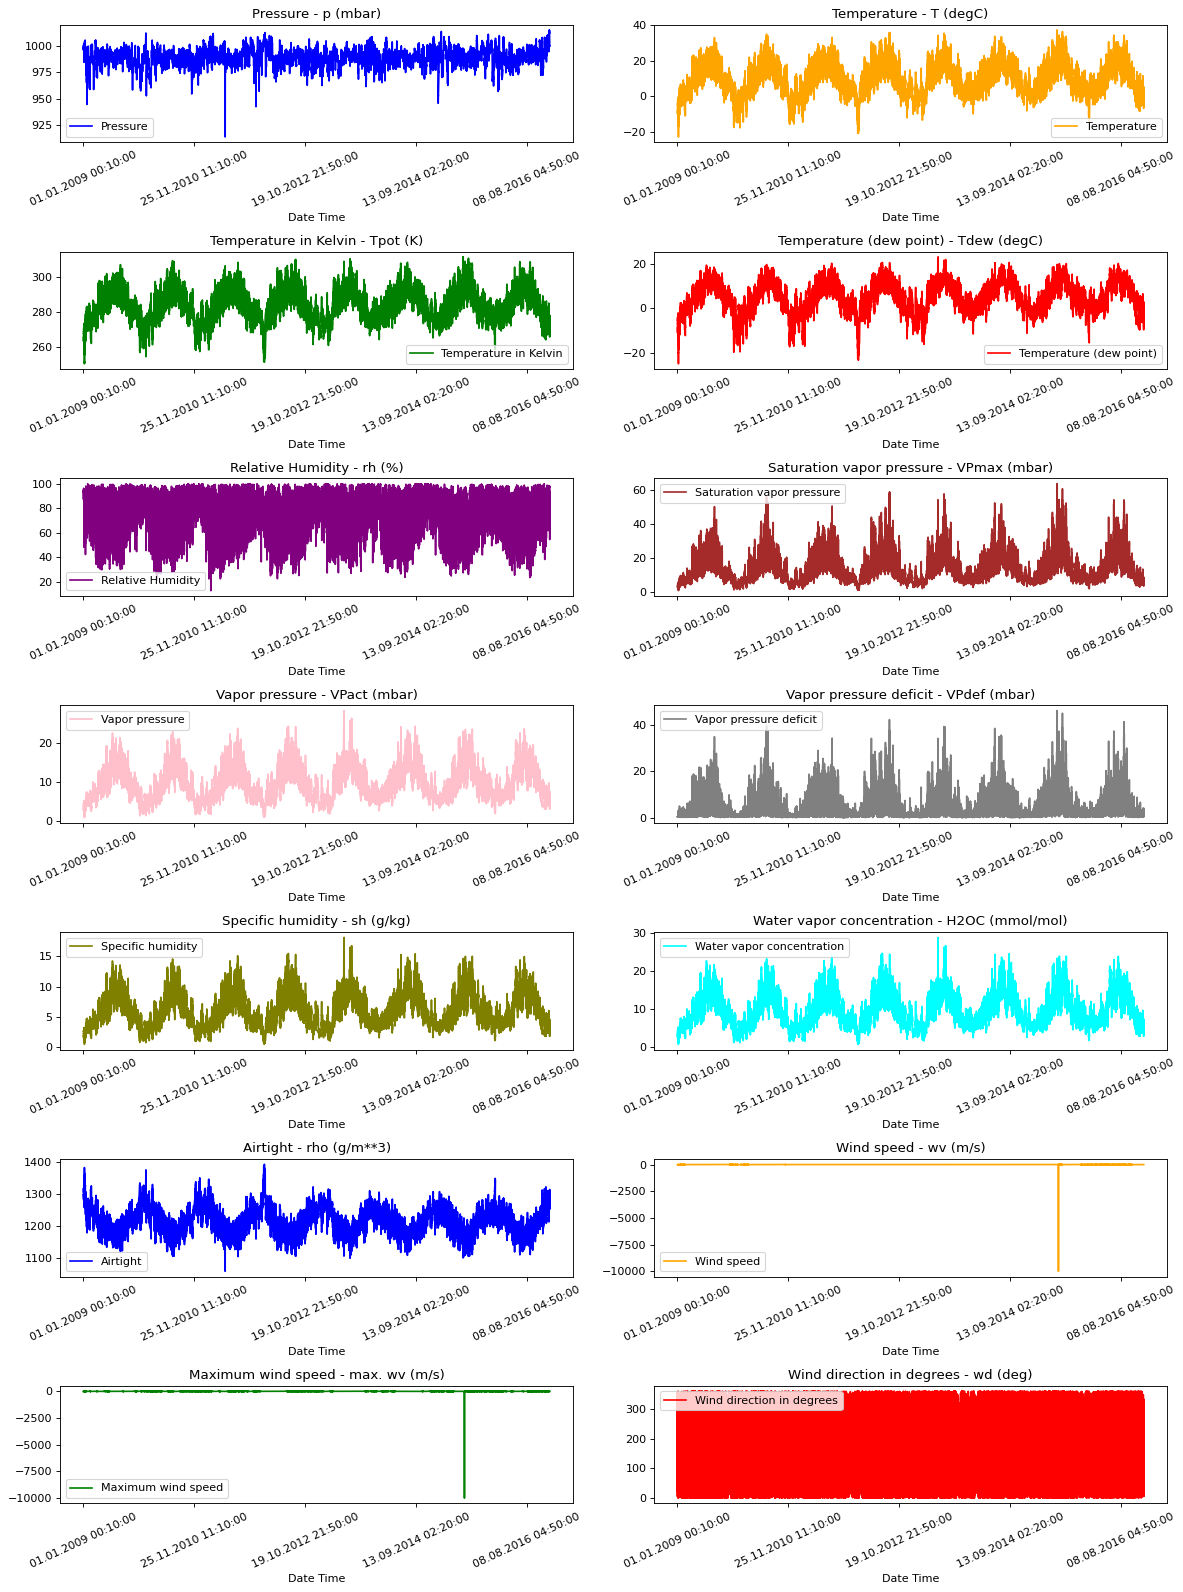

In [10]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

히트맵 도표를 통해, 각 14개의 컬럼이 다른 14개의 컬럼과

얼마 만큼의 상관계수를 갖는지 알 수 있습니다.

예를 들어, p(mbar)은 기압을 나타내는데, x축의 p(mbar)과 y축의 p(mbar)은

같은 값을 가지므로 +1 의 상관관계를 갖습니다.

이와 같은 경우, 우측의 색깔 도표에 따라 노란색을 띠게 됩니다.

만약 상관관계가 -1인 두 변수 A,B가 존재한다면, 해당 A, B의 히트맵 네모칸 색깔은

보라색으로 표기되겠지요.

이와 같이 히트맵(Heatmap)을 통해 두 변수 간의 상관관계를

눈으로 파악할 수 있습니다.

<ipython-input-11-cf6ad4dd723a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


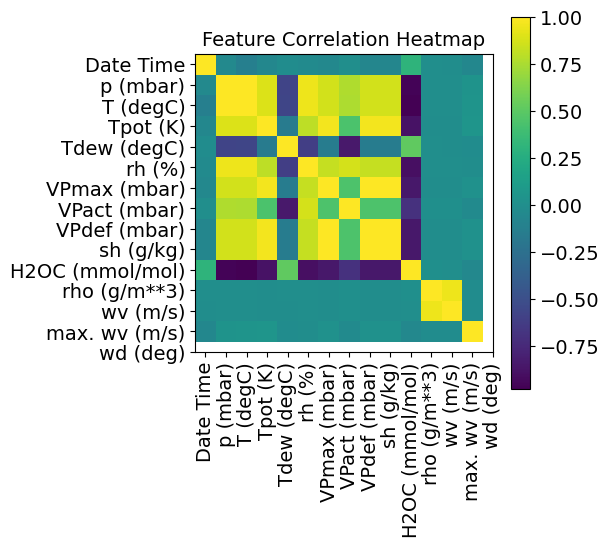

In [11]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


## 데이터 전처리

학습 / 테스트 / 검증 데이터를 나누어(split) 줍니다.

날씨 데이터는 10분마다, 1시간에 6번 기록되는데,

분석 편의를 위해 1시간에 1개의 데이터만을 사용하도록

클렌징해 줍시다.

'timeseries_dataset_from_array' 함수에서 'sampling_rate'를

조절하여 이 작업을 해 줍니다.

향후 날씨 데이터(T)를 예측하기 위해,

직전의 720개의 온도데이터를 활용하여 (T-720, T-719, T-718, ... , T-2, T-1)
온도 데이터(T)를 예측합니다. (720 / 6 = 120 시간)

또한 정규화를 하여 데이터가 [0, 1] 구간에 들어오도록 조정해 준 후,

기계학습에 사용하도록 하겠습니다.

N = (T - mean) / Std
N = (T - 평균) / (표준편차)

학습 / 테스트 / 검증 데이터를 분할할 때,
학습 데이터셋의 비율은 71.5%입니다. (약 300,693 행)

In [12]:
# 머신러닝 인자 입력
# 71.5%를 학습 데이터로, 나머지를 테스트 및 검증 데이터로 분류해 줍니다.
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

# 과거 데이터 720건, 미래 데이터 72건
past = 720
future = 72
# 아래 learning rate (학습률), batch size(), epochs(반복수)는
# 기계학습 시행시 설정해주어야 하는 옵션값입니다.
# 자세한 내용은 아래 기계학습 기초서나 문헌, 동영상 등을 참고하세요!!
#
learning_rate = 0.001 #학습률
batch_size = 256 #분할한 데이터 단위 (256개가 한 묶음)
epochs = 10 #반복 횟수 # 원래 epoch는 10이지만, 실행속도 때문에 2번만 학습시켜 봅시다.

### 머신러닝 인자 설명

****** 학습률(Learning Rate) </br>

경사하강법에서 시작점에서 다음점으로 이동할 때 보폭(학습률) 만큼 이동한 점을 다음점으로 정한다고 하였습니다. 학습률이란, 현재점에서 다음점으로 얼만큼 이동할지, 다르게 말하면 모델이 얼마나 세세하게 학습을 할지를 말합니다.

![기계학습 학습률](https://github.com/dscoool/dscoool.github.io/raw/main/resources/learning_rate.jpeg)

학습률이 작다면 손실이 최적인 가중치를 찾는데 오랜 시간이 걸릴 것이며, 학습률이 너무 크다면 최적점을 무질서하게 이탈할 수도 있습니다.

초매개변수(Hyperparameter - 하이퍼파라미터)
학습률과 같이 기계학습을 할 때 우리가 직접 조종하는 인자를 초매개변수라고 합니다.

'최적화'란 학습률 및 머신러닝 인자를 여러 번 입력해보고,

가장 효율적인 수치(학습률 등)를 찾아 활용합니다.
Reference: https://codingrabbit.tistory.com/11

****** 배치 사이즈(batch size) </br>
****** 에포크(epoch) </br>
****** 반복(iteration) </br>

1. 사전적 의미
2. batch size의 의미
3. epoch의 의미
4. iteration의 의미

배치 사이즈(batch size) vs 에포크(epoch) vs 반복(iteration)의 차이

딥러닝을 하다보며 에포크(epoch), 배치(batch), 반복(iteration)이라는 단어를 많이 접하게 됩니다. 그런데 이 단어들이 다 비슷비슷한 느낌이라 처음에는 헷갈릴 수 있는데요. 여기서는 epoch, batch, iteration의 차이에 대해 알아보겠습니다.

1. 사전적 의미
먼저 batch 의 사전적 의미를 보겠습니다. batch를 영어사전에 검색하면 아래와 같은 뜻이 나옵니다. batch 는 일괄적이라는 뜻이 포함되네요.

batch

(일괄적으로 처리되는) 집단, 무리
한 회분(한 번에 만들어 내는 음식기계 등의 양)
(일괄 처리를 위해) 함께 묶다

다음은 epoch의 사전적 의미를 보겠습니다. epoch는 시대라는 뜻으로 batch와는 조금 다른 느낌이 듭니다.

epoch

(중요한 사건·변화들이 일어난) 시대 (=era)

마지막으로 iteration을 검색해보겠습니다. iteration은 ‘반복’이라는 뜻으로 흔히 반복문할 때 그 반복이라고 생각하시면 이해가 쉬울 것 같습니다.

iteration

(계산·컴퓨터 처리 절차의) 반복

2. batch size의 의미
batch size란 정확히 무엇을 의미할까요? 전체 트레이닝 데이터 셋을 여러 작은 그룹을 나누었을 때 batch size는 하나의 소그룹에 속하는 데이터 수를 의미합니다. 전체 트레이닝 셋을 작게 나누는 이유는 트레이닝 데이터를 통째로 신경망에 넣으면 비효율적이 리소스 사용으로 학습 시간이 오래 걸리기 때문입니다.


3. epoch의 의미
딥러닝에서 epoch는 전체 트레이닝 셋이 신경망을 통과한 횟수 의미합니다. 예를 들어, 1-epoch는 전체 트레이닝 셋이 하나의 신경망에 적용되어 순전파와 역전파를 통해 신경망을 한 번 통과했다는 것을 의미합니다.


4. iteration의 의미
마지막으로 iteration은 1-epoch를 마치는데 필요한 미니배치 갯수를 의미합니다. 다른 말로, 1-epoch를 마치는데 필요한 파라미터 업데이트 횟수 이기도 합니다. 각 미니 배치 마다 파라미터 업데이터가 한번씩 진행되므로 iteration은 파라미터 업데이트 횟수이자 미니배치 갯수입니다. 예를 들어, 700개의 데이터를 100개씩 7개의 미니배치로 나누었을때, 1-epoch를 위해서는 7-iteration이 필요하며 7번의 파라미터 업데이트가 진행됩니다.

Reference: https://losskatsu.github.io/machine-learning/epoch-batch/

In [13]:
# 정규화 작업 함수 - 정규분포로 만듭니다.
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

상관관계 히트맵을 보면, 상대 습도(Relative Humidity)와 상세 습도(Specific Humidity)가 연관관계가 있는 것을 볼 수 있어요!!

이와 같이 두 변수 간 상관관계가 강한 변수들이 몇 개 있습니다.

이렇게 특정 상관관계가 강한 변수들만을 선택하여 머신러닝 작업을 진행하도록 하겠습니다!!

In [14]:
print(
    "상관관계가 높은 변수를 선택합니다:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

상관관계가 높은 변수를 선택합니다: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


## 학습 데이터셋

792번부터 학습 데이터셋입니다 (720 + 72)

In [15]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

LSTM을 시행할 때, 'timeseries_dataset_from_array' 함수는
'움직이는 창문' (sliding_windows)과 같은 역할을 합니다.

(T-720, T-719, ... , T-2, T-1)의 데이터 포인트를 수집할 때,

T가 오른쪽으로 한 칸 움직이면 'timeseries_dataset_from_array'함수 역시

오른쪽으로 shift하여 최근 720개의 데이터 포인트를 수집합니다.

학습할 데이터셋을 지정해 줍니다.

X = x_train (원인)  </br>

y = y_train (결과) </br>

sampling_rate = 학습속도 </br>

batch size = 1개의 묶음에 포함된 데이터의 수 (256)

In [16]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## 검증 데이터셋

머신러닝의 3단계인

a. 학습(Training)
b. 테스트(Test)
c. 검증(Validation)

중 학습과 테스트를 완료하고 나면,

X값을 모델에 입력하여 y값을 예측할 수 있게 됩니다.

이제 X값 792개 만을 이용하여 y값을 예측해 봅시다!!

train_split 과 past + future(792)를 더하여 그 부분부터 label_start로 지정합니다.

In [17]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("입력 데이터 형태:", inputs.numpy().shape)
print("출력 데이터 형태:", targets.numpy().shape)

입력 데이터 형태: (256, 120, 7)
출력 데이터 형태: (256, 1)


## 학습 (Training)

이제 keras의 LSTM모델을 이용하여 학습해 봅시다.

X --> LSTM --> Y

여기서 X, Y데이터셋을 제공하여,

LSTM모델이 데이터를 학습하여 적응할 수 있도록 만들어 주는 작업을

학습(Training)이라고합니다.

학습을 마치고 나면,

X값을 입력하면 LSTM이 예측한 y값을 출력해 주게 됩니다.



* LSTM 설명 - http://www.incodom.kr/LSTM


inputs           lstm_out                     outputs

120 x 7       LSTM - LSTM - ... - LSTM         1
개의 데이터 입력  데이터포인트 한 개 당 LSTM 32개 사용   결과값은 y값 1개로 출력

하루의 날씨 데이터    32개의 LSTM 예측 모델            기온
                                               습도
                                               ...
                                               

* LSTM은 전일의 날씨가 하루 뒤, 이틀 뒤의 날씨에 영향을 미친다는 점을 고려한

예측 모델입니다. 장단기기억(Lont Short Term Memory)라는 명칭은

모델이 D-3, D-2의 기온, 습도 등을 기억하고 있다가 D에 활용한다는 점을 의미합니다.

In [18]:
# 모델의 형태를 설정해 줍니다.
# 도입부 - 120 x 7 형태의 테이블
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# 중간 LSTM 사용 횟수 - 32겹 32 layers
lstm_out = keras.layers.LSTM(32)(inputs)
# 출력부 - 1개의 값을 출력
outputs = keras.layers.Dense(1)(lstm_out)

# 위의 inputs, lstm_out, outputs 설정값대로 모델을 설정합니다.
model = keras.Model(inputs=inputs, outputs=outputs) # LSTM 머신러닝 모델
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary() # 모델이 어떤 구조로 형성되었는지 결과값 출력

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ModelCheckpoint = 임시저장을 하여 중단시 그 부분부터 다시 시작할 수 있도록 설정합니다.
EarlyStopping = 머신러닝이 학습을 거의 완료하여 검증 손실률(validation)이
더이상 증가하지 않으면 학습을 그 단계에서 중단합니다.

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# 원래 epoch=10으로 10번 반복하여 모델을 학습하여야 하나,
# 시간이 오래 걸리는 관계로 epoch=2로 설정합니다.
# 한 번(1 epoch) 학습 수행시 1,172개의 데이터를 학습합니다.
# validation_data 는 학습을 마치고 나서 실제 예측을 수행해 볼
# 데이터셋을 말합니다.
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2160
Epoch 1: val_loss improved from inf to 0.16711, saving model to model_checkpoint.h5
1172/1172 [==============================] - 197s 161ms/step - loss: 0.2160 - val_loss: 0.1671
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1290
Epoch 2: val_loss improved from 0.16711 to 0.13823, saving model to model_checkpoint.h5
1172/1172 [==============================] - 191s 163ms/step - loss: 0.1290 - val_loss: 0.1382
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1163
Epoch 3: val_loss did not improve from 0.13823
1172/1172 [==============================] - 184s 157ms/step - loss: 0.1163 - val_loss: 0.1427
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1112
Epoch 4: val_loss did not improve from 0.13823
1172/1172 [==============================] - 182s 155ms/step - loss: 0.1112 - val_loss: 0.1426
Epoch 5/10
1172/1172 [================

학습을 여러 번 반복하다 보면 손실률이 더이상 변하지 않는 지점이 있는데,

여기서 학습(epoch)을 중단하면 됩니다. 이를 시각화해봅시다.

In [ ]:
# 손실률 계산 함수
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## 예측 작업

검증(validation) 데이터셋 5개를 사용하여
날씨 데이터를 예측해 봅시다.

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

8/8 [==============================] - 1s 15ms/step


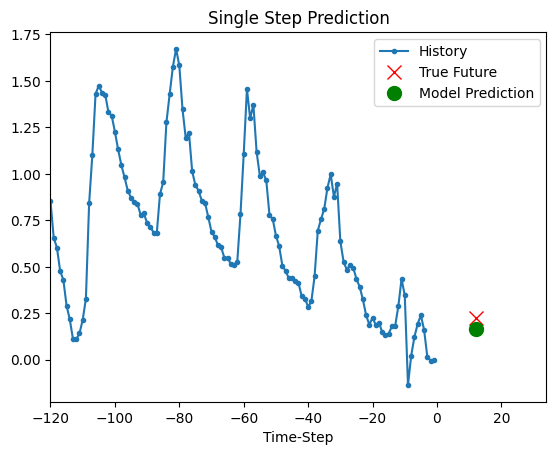

8/8 [==============================] - 0s 16ms/step


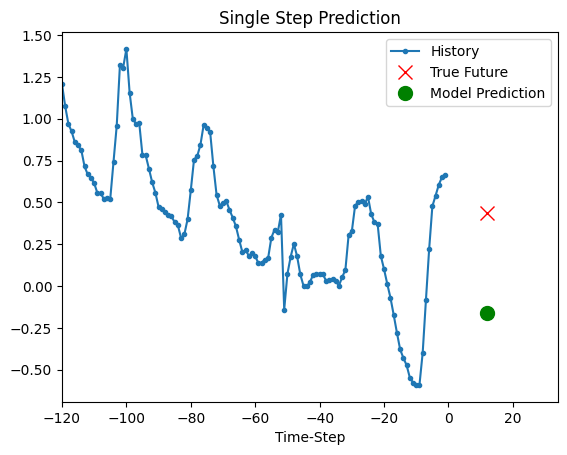

8/8 [==============================] - 0s 17ms/step


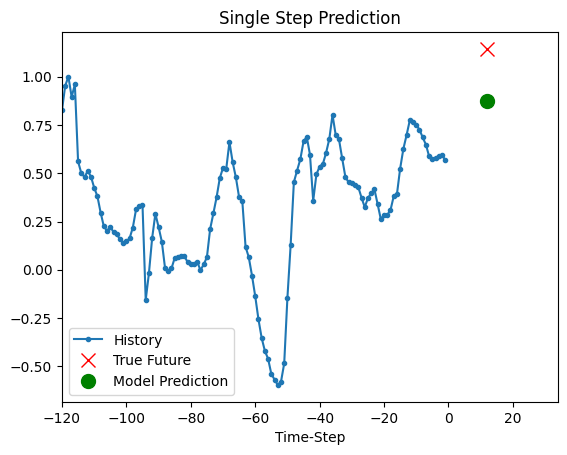

8/8 [==============================] - 0s 14ms/step


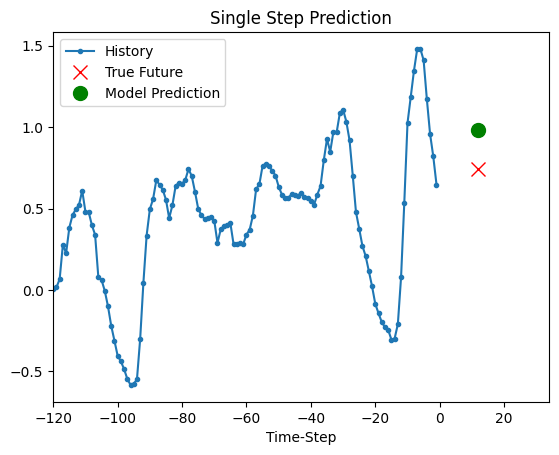

8/8 [==============================] - 0s 15ms/step


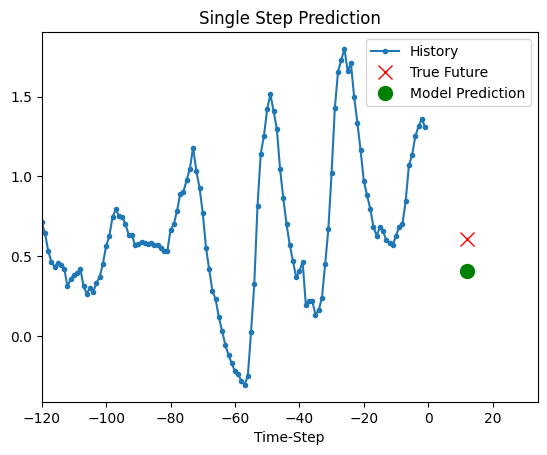

In [ ]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


Reference:
1. https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_weather_forecasting.py
2. https://codingrabbit.tistory.com/11
3. https://losskatsu.github.io/machine-learning/epoch-batch/
